In [1]:
import math
import time
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_distribution
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit

In [2]:
vertices_num = 6
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4)]
edges_num = len(edges)

search_num = 9

qubits = math.ceil(math.log2(edges_num + 1))
search_num_b = list(format(search_num, f'0{qubits}b'))
shorts = 10000

for (i,v) in enumerate(search_num_b):
    search_num_b[i] = int(v)

qubits_num = vertices_num + qubits + edges_num + 1

iteration_num = math.floor(math.pi/4*math.sqrt(2**vertices_num))

In [10]:
backend = AerSimulator()
backend.set_options(shots=shorts)

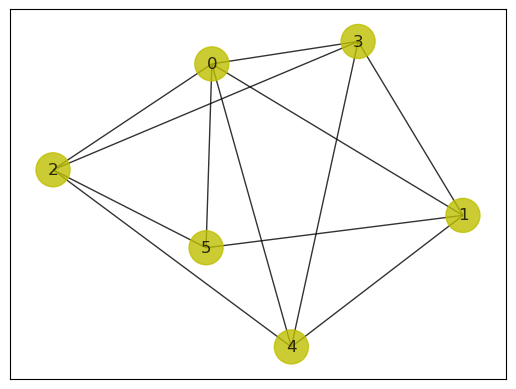

In [11]:
G = nx.Graph()
G.add_nodes_from(range(vertices_num))
G.add_edges_from(edges)

colors = ['y' for node in G.nodes()]    
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)   

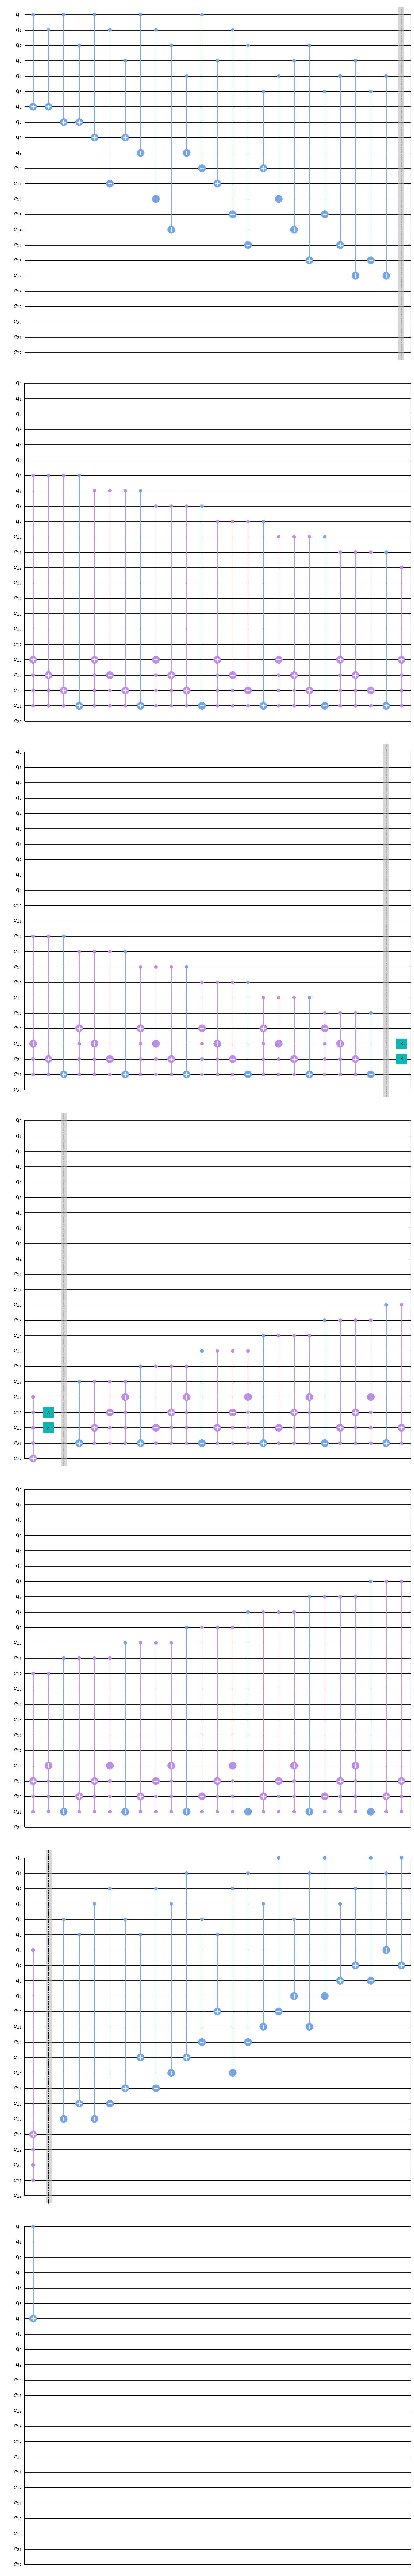

In [12]:
oracle = QuantumCircuit(qubits_num, name='oracle')

for i,e in enumerate(edges):
    oracle.cx(e[0], vertices_num + i)
    oracle.cx(e[1], vertices_num + i)
oracle.barrier()

for i,e in enumerate(edges):
    for j in range(1, qubits):
        control = list(range(vertices_num+edges_num+j, vertices_num+edges_num+qubits))
        control.append(vertices_num + i)
        oracle.mcx(control, vertices_num+edges_num+j-1)
    oracle.cx(vertices_num+i, vertices_num+edges_num+qubits-1)
oracle.barrier()

for i,v in enumerate(search_num_b):
    if v == 0:
        oracle.x(vertices_num+edges_num+i)
oracle.mcx(list(range(vertices_num+edges_num, vertices_num+edges_num+qubits)), vertices_num+edges_num+qubits)

for i,v in enumerate(search_num_b):
    if v == 0:
        oracle.x(vertices_num+edges_num+i)
oracle.barrier()

for i,e in list(enumerate(edges))[::-1]:
    oracle.cx(vertices_num+i, vertices_num+edges_num+qubits-1)
    for j in list(range(1, qubits))[::-1]:
        control = list(range(vertices_num+edges_num+j, vertices_num+edges_num+qubits))
        control.append(vertices_num + i)
        oracle.mcx(control, vertices_num+edges_num+j-1)
oracle.barrier()

for i,e in list(enumerate(edges))[::-1]:
    oracle.cx(e[1], vertices_num + i)
    oracle.cx(e[0], vertices_num + i)

oracle.draw('mpl')

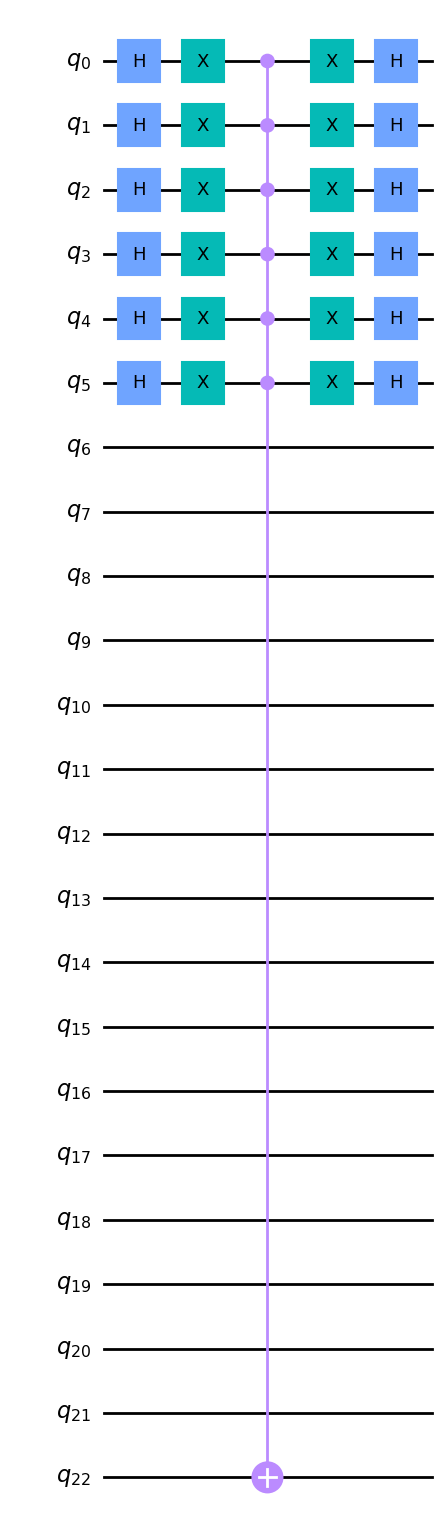

In [13]:
diffuser = QuantumCircuit(qubits_num, name='diffusion')

for i in range(vertices_num):
    diffuser.h(i)
    diffuser.x(i)
diffuser.mcx(list(range(vertices_num)), vertices_num+edges_num+qubits)

for i in range(vertices_num):
    diffuser.x(i)
    diffuser.h(i)
diffuser.draw('mpl')

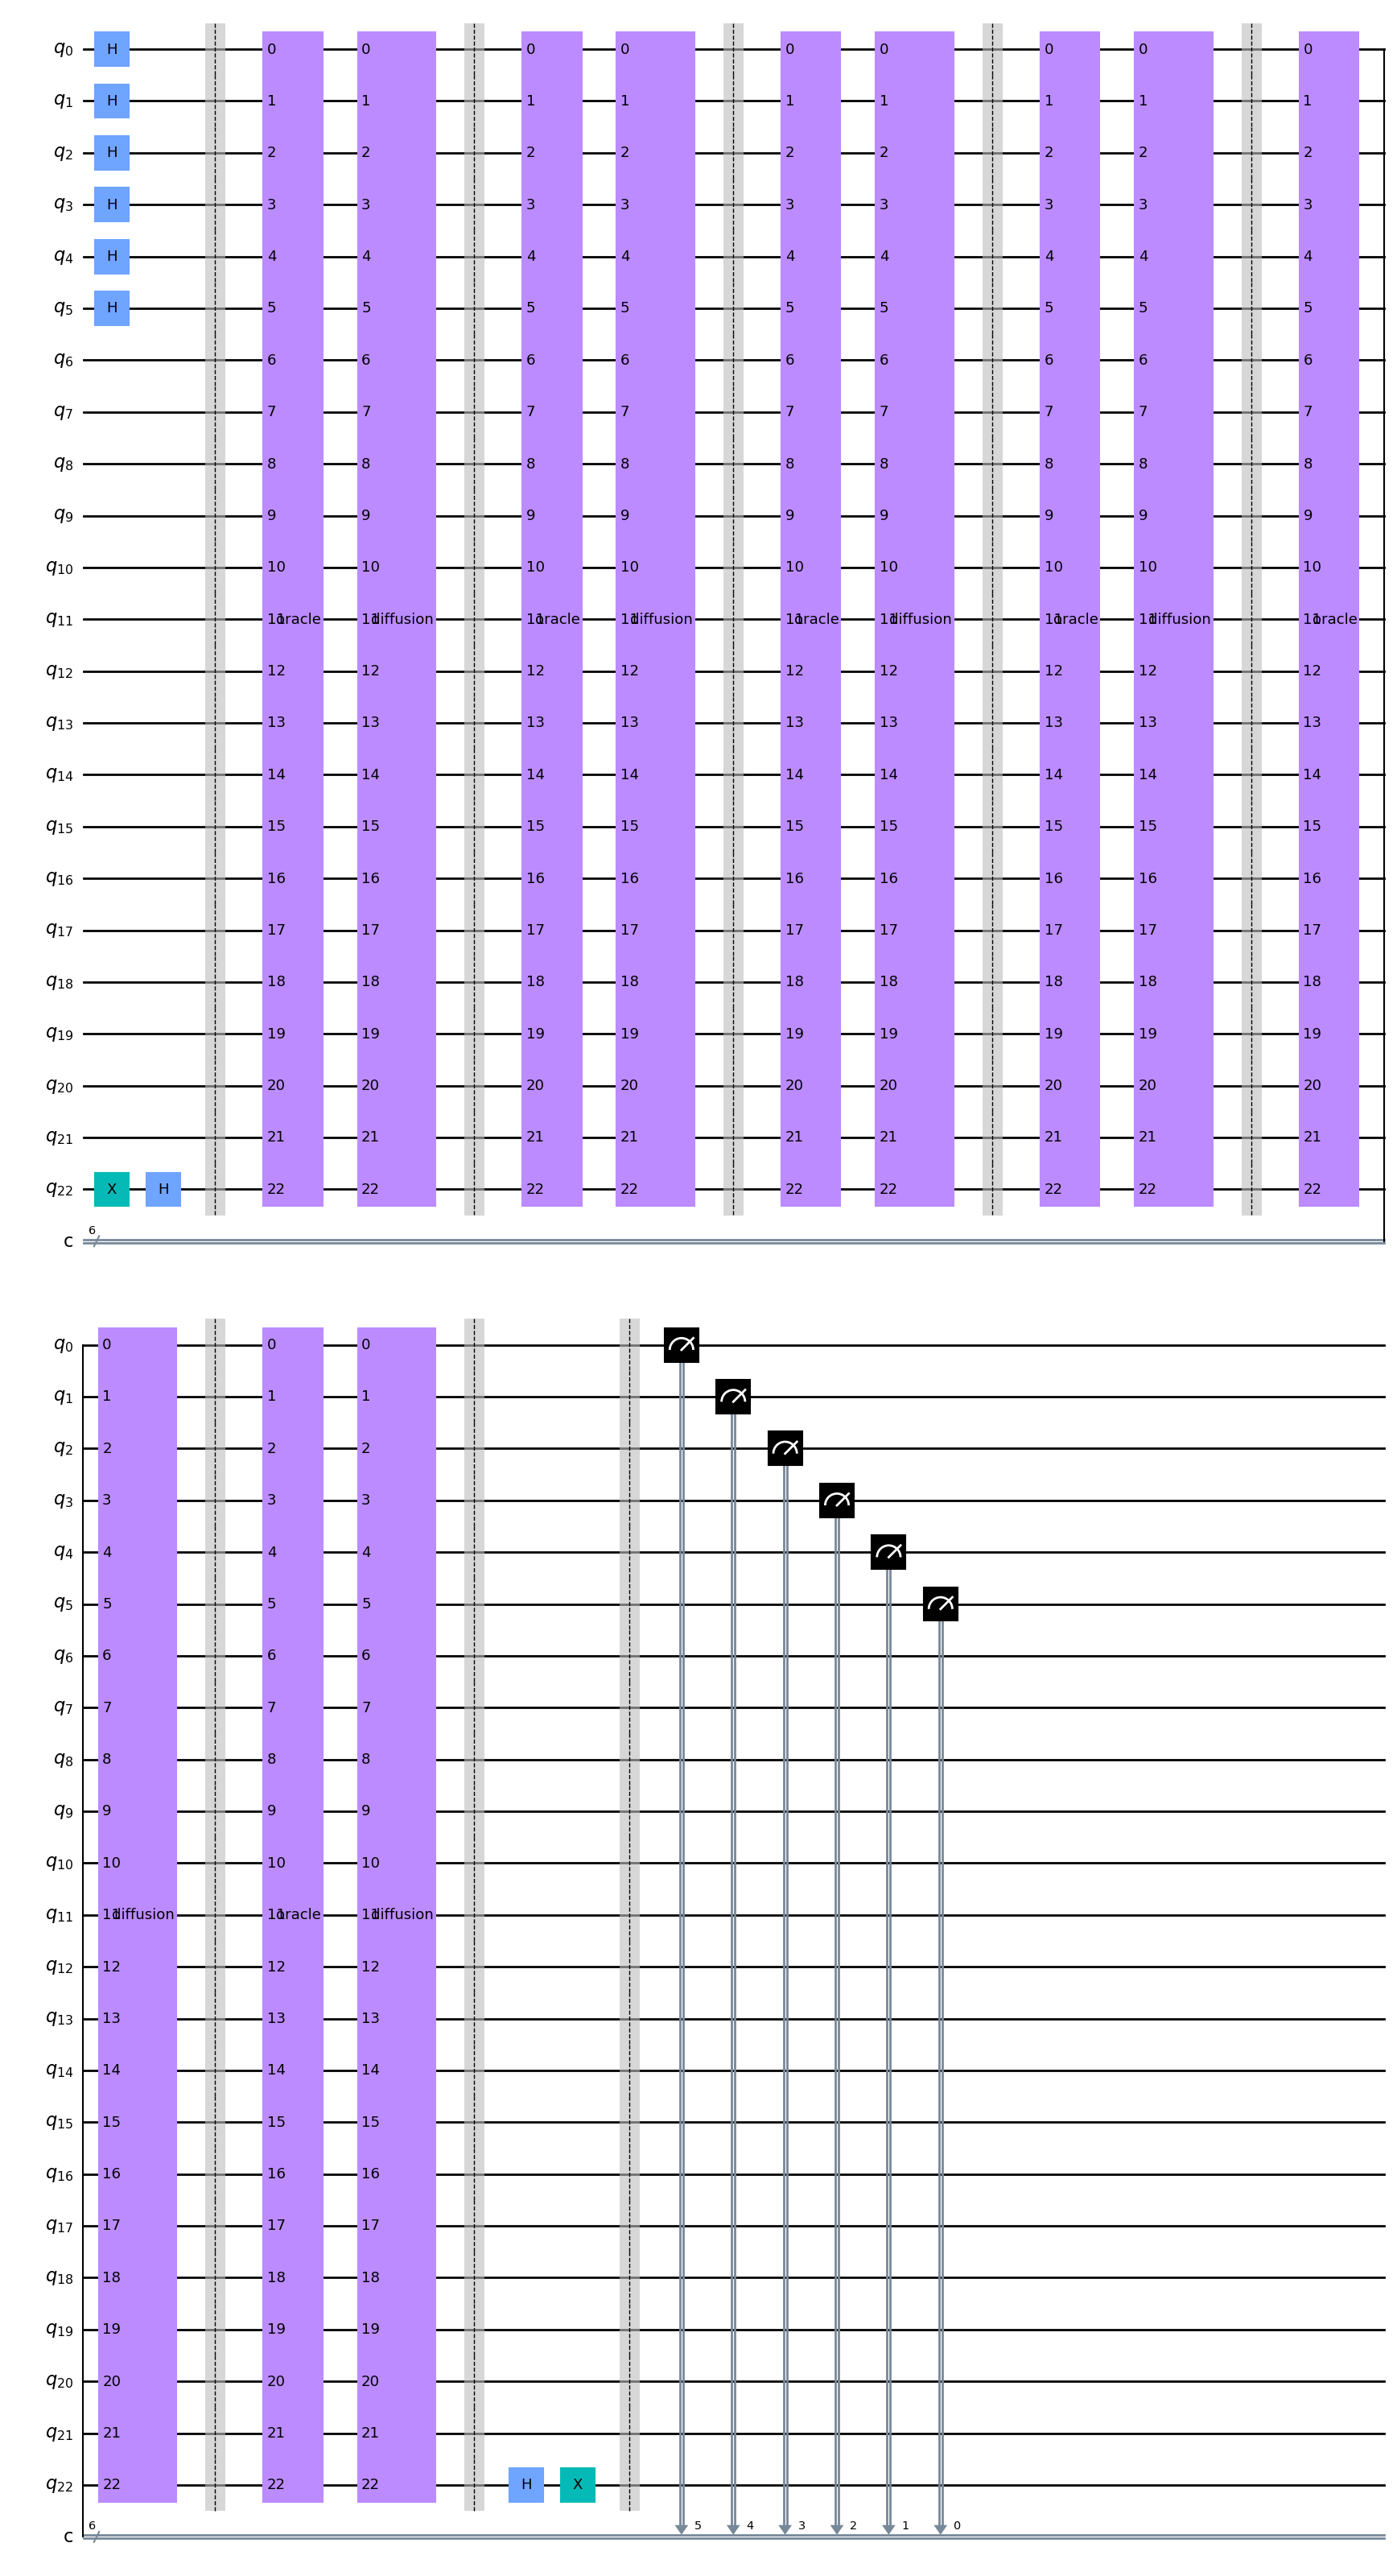

In [14]:
gate_oracle = oracle.to_instruction()
gate_diffuser = diffuser.to_instruction()

qc = QuantumCircuit(qubits_num, vertices_num)

for i in range(vertices_num):
    qc.h(i)

qc.x(vertices_num+edges_num+qubits)
qc.h(vertices_num+edges_num+qubits)
qc.barrier()

for i in range(iteration_num):
    qc.append(gate_oracle, range(qubits_num))
    qc.append(gate_diffuser, range(qubits_num))
    qc.barrier()

qc.h(vertices_num+edges_num+qubits)
qc.x(vertices_num+edges_num+qubits)
qc.barrier()

for i in range(vertices_num):
    qc.measure(i, vertices_num-i-1)

qc.draw('mpl')

In [15]:
passmanager = PassManager()
passmanager.append(RemoveBarriers())
transpiled_qc = passmanager.run(qc)
transpiled_qc = transpile(transpiled_qc, backend=backend, optimization_level=3)

job = backend.run(transpiled_qc)

result = job.result()
counts = result.get_counts(transpiled_qc)

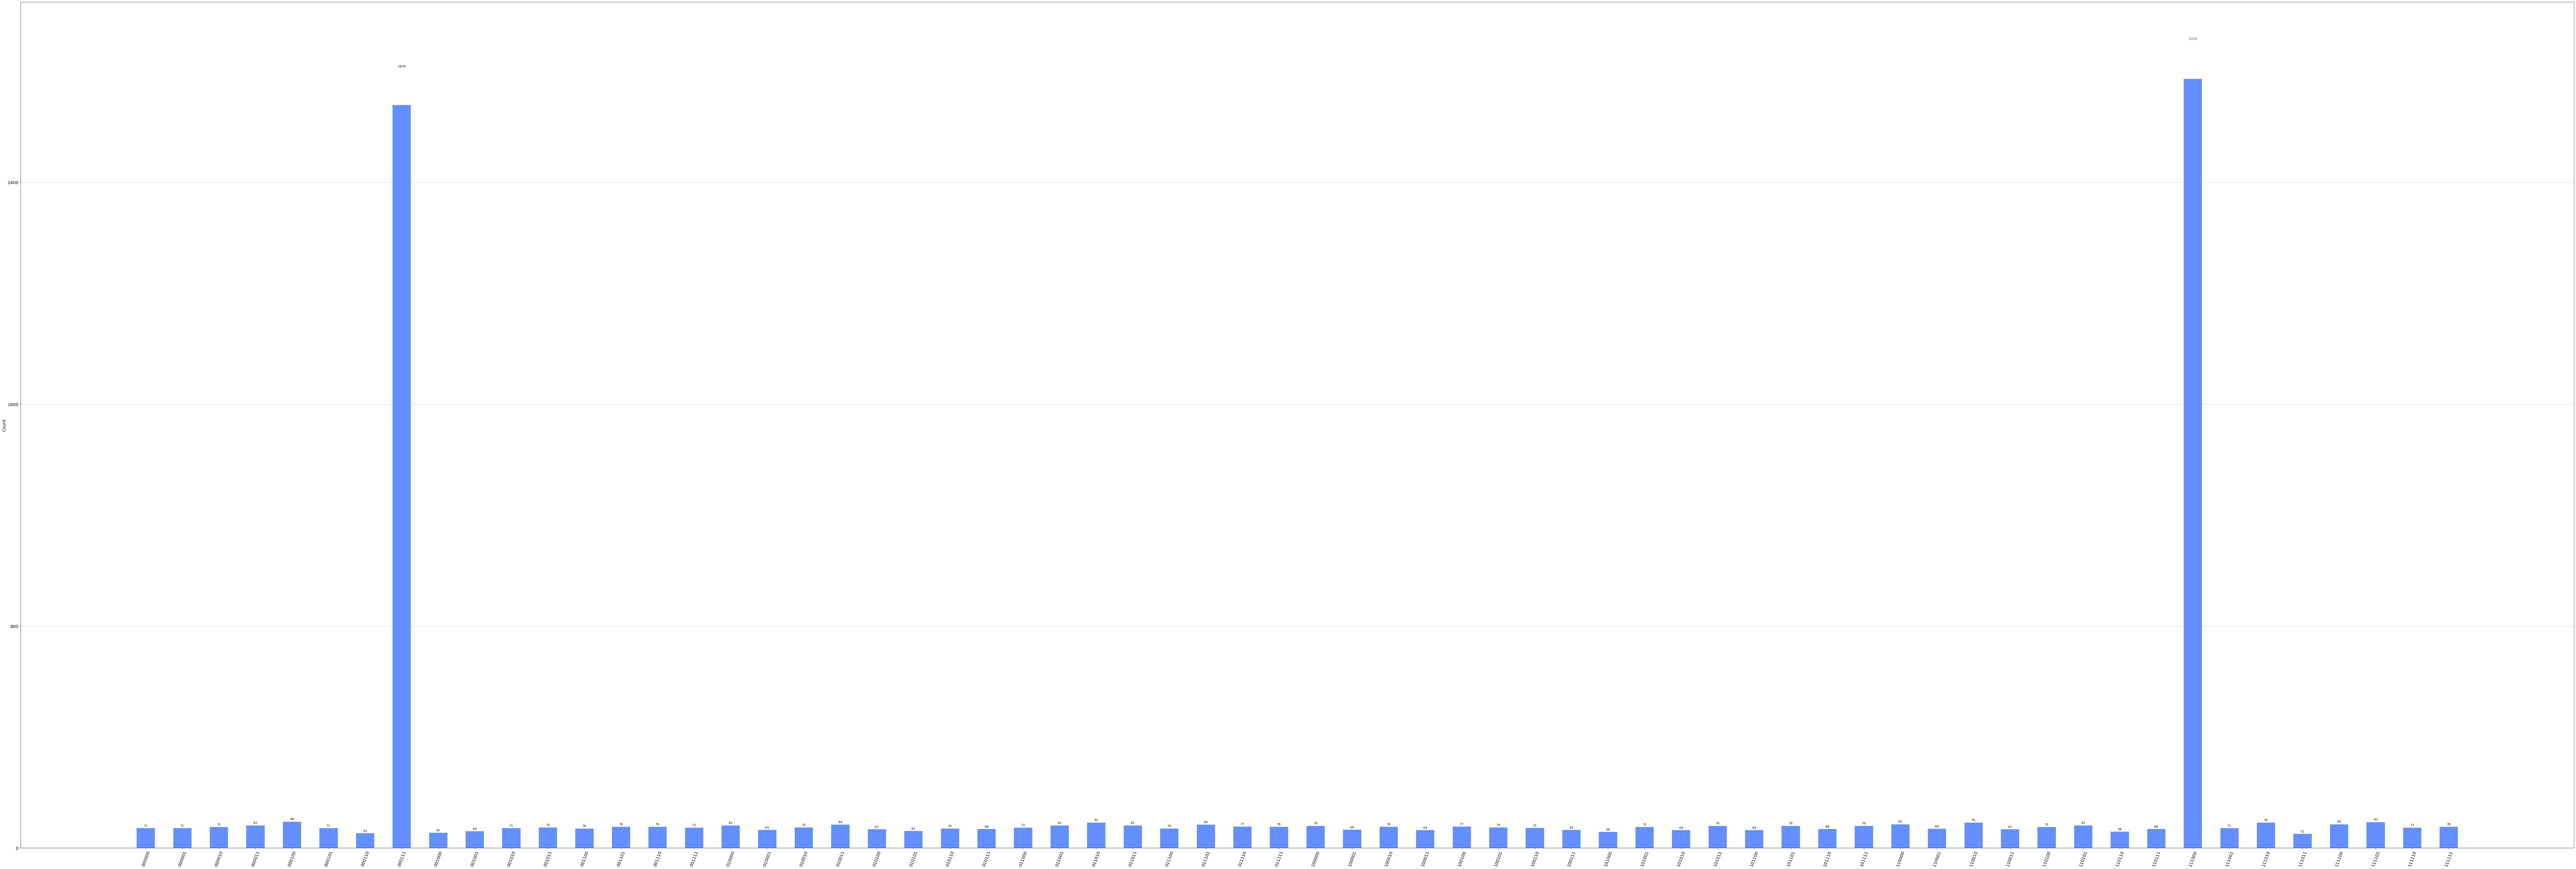

In [19]:
from qiskit.visualization import plot_histogram as ph
ph(result.get_counts(qc),figsize=(150,50))